In [91]:
import numpy as np
import matplotlib.pyplot as plt

In [92]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

BIG_SIZE = 14
BIGGER_SIZE = 16
BIGGEST_SIZE = 20

matplotlib.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=BIG_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=BIGGEST_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [93]:
# An implementation of the CRPS function according the PWM form
def crps(y_true, y_pred, sample_weight=None):
    num_samples = y_pred.shape[0]
    absolute_error = np.mean(np.abs(y_pred - y_true), axis=0)

    if num_samples == 1:
        return np.average(absolute_error, weights=sample_weight)

    y_pred = np.sort(y_pred, axis=0)
    b0 = y_pred.mean(axis=0)
    b1_values = y_pred * np.arange(num_samples).reshape((num_samples, 1))/ (num_samples - 1)
    b1 = b1_values.mean(axis=0) # made a correction in the original code ! N-1 instead of N

    per_obs_crps = absolute_error + b0 - 2 * b1
    return np.average(per_obs_crps, weights=sample_weight)

In [94]:
data_cg1 = np.load('../../../deterministic/224x32/data_at_more_obs_points_config1/coarse_grained_vel_temp_data_t=25.0_to_t=35.0_grid_32_more_obs_config1.npz')
data_cg2 = np.load('../../../deterministic/224x32/data_at_more_obs_points_config1/coarse_grained_vel_temp_data_t=35.0_to_t=45.0_grid_32_more_obs_config1.npz')
data_det = np.load('../../../deterministic/224x32/data_at_more_obs_points_config1/vel_temp_det_data_t25_onwards_m_obs.npz')

In [95]:
ua_truth_t1 = data_cg1['ua_truth'] # t25 to t35
ua_truth_t2 = data_cg2['ua_truth'] # t35 to t45
Ta_truth_t1 = data_cg1['Ta_truth'] # t25 to t35
Ta_truth_t2 = data_cg2['Ta_truth'] # t35 to t45
ua_det = data_det['ua_data_det']
Ta_det = data_det['Ta_data_det']

In [96]:
ua_truth_t1.shape, ua_truth_t2.shape

((10, 84, 2), (11, 84, 2))

In [97]:
gridpoints = data_cg1['gridpoints']
print(f'gridpoints: {gridpoints}')

gridpoints: [[0.   0.25]
 [0.25 0.25]
 [0.5  0.25]
 [0.75 0.25]
 [1.   0.25]
 [1.25 0.25]
 [1.5  0.25]
 [1.75 0.25]
 [2.   0.25]
 [2.25 0.25]
 [2.5  0.25]
 [2.75 0.25]
 [3.   0.25]
 [3.25 0.25]
 [3.5  0.25]
 [3.75 0.25]
 [4.   0.25]
 [4.25 0.25]
 [4.5  0.25]
 [4.75 0.25]
 [5.   0.25]
 [5.25 0.25]
 [5.5  0.25]
 [5.75 0.25]
 [6.   0.25]
 [6.25 0.25]
 [6.5  0.25]
 [6.75 0.25]
 [0.   0.5 ]
 [0.25 0.5 ]
 [0.5  0.5 ]
 [0.75 0.5 ]
 [1.   0.5 ]
 [1.25 0.5 ]
 [1.5  0.5 ]
 [1.75 0.5 ]
 [2.   0.5 ]
 [2.25 0.5 ]
 [2.5  0.5 ]
 [2.75 0.5 ]
 [3.   0.5 ]
 [3.25 0.5 ]
 [3.5  0.5 ]
 [3.75 0.5 ]
 [4.   0.5 ]
 [4.25 0.5 ]
 [4.5  0.5 ]
 [4.75 0.5 ]
 [5.   0.5 ]
 [5.25 0.5 ]
 [5.5  0.5 ]
 [5.75 0.5 ]
 [6.   0.5 ]
 [6.25 0.5 ]
 [6.5  0.5 ]
 [6.75 0.5 ]
 [0.   0.75]
 [0.25 0.75]
 [0.5  0.75]
 [0.75 0.75]
 [1.   0.75]
 [1.25 0.75]
 [1.5  0.75]
 [1.75 0.75]
 [2.   0.75]
 [2.25 0.75]
 [2.5  0.75]
 [2.75 0.75]
 [3.   0.75]
 [3.25 0.75]
 [3.5  0.75]
 [3.75 0.75]
 [4.   0.75]
 [4.25 0.75]
 [4.5  0.75]
 [4.75 0.75]


In [98]:
ua_truth = np.concatenate((ua_truth_t1, ua_truth_t2), axis=0)
Ta_truth = np.concatenate((Ta_truth_t1, Ta_truth_t2), axis=0)

In [99]:
ua_truth.shape, Ta_truth.shape

((21, 84, 2), (21, 84))

In [100]:
n_tsteps = 21 
n_obs_points = gridpoints.shape[0]

In [101]:
crps_ux_one_det = np.zeros((n_tsteps, 1)) # calculate crps at each time step
crps_uy_one_det = np.zeros((n_tsteps, 1))
crps_temp_one_det = np.zeros((n_tsteps, 1))
for t in range(n_tsteps):
    truth_mat_ux = ua_truth[t, :,0].reshape(1, -1)
    truth_mat_uy = ua_truth[t, :,1].reshape(1, -1)
    truth_mat_temp = Ta_truth[t, :].reshape(1, -1)

    obs_mat_ux = ua_det[t, :,0].reshape(1, -1)
    obs_mat_uy = ua_det[t, :,1].reshape(1, -1)
    obs_mat_temp = Ta_det[t, :].reshape(1, -1)


    crps_ux_one_det[t] = crps(truth_mat_ux, obs_mat_ux)
    crps_uy_one_det[t] = crps(truth_mat_uy, obs_mat_uy)
    crps_temp_one_det[t] = crps(truth_mat_temp, obs_mat_temp)

In [102]:
def ensem_crps_t(n_tsteps, n_stoch, var_level, ua_truth, Ta_truth):
    """
    returns average of ensemble crps over all observation points for ux, uy, temp
    :param n_tsteps: number of time steps
    :param ua_truth: true velocity
    :param Ta_truth: true temperature
    :param n_stoch: number of particles in the ensemble
    :param var_level: variance level of the ensemble 
    """
    crps_ux_t = np.zeros((n_tsteps, 1)) # calculate crps at each time step
    crps_uy_t = np.zeros((n_tsteps, 1))
    crps_temp_t = np.zeros((n_tsteps, 1))

    n_obs_points = Ta_truth.shape[1]

    for t in range(n_tsteps):
        obs_mat_ux = np.zeros((n_stoch, n_obs_points)) # arrange observations in a suitable form at each tstep
        truth_mat_ux = ua_truth[t, :,0].reshape(1, -1)

        obs_mat_uy = np.zeros((n_stoch, n_obs_points))
        truth_mat_uy = ua_truth[t, :,1].reshape(1, -1)

        obs_mat_temp = np.zeros((n_stoch, n_obs_points))
        truth_mat_temp = Ta_truth[t, :].reshape(1, -1)

        for k in range(n_stoch):
            data_stoch = np.load('../data_stoch_more_obs/vel_temp_data_m_obs_particle_'+str(k+1)+'_var_'+str(var_level)+'_grid_32_t25_onwards_OU_same_ic.npz')
            vel_data_stoch = data_stoch['ua_data_sto']  
            temp_data_stoch = data_stoch['Ta_data_sto'] 
            obs_mat_ux[k, :] = vel_data_stoch[t, :, 0] # each row of observation matrix correspond to a particle's value at observation points
            obs_mat_uy[k, :] = vel_data_stoch[t, :, 1]
            obs_mat_temp[k, :] = temp_data_stoch[t, :]

        crps_ux_t[t] = crps(truth_mat_ux, obs_mat_ux)
        crps_uy_t[t] = crps(truth_mat_uy, obs_mat_uy)
        crps_temp_t[t] = crps(truth_mat_temp, obs_mat_temp)
    
    return crps_ux_t, crps_uy_t, crps_temp_t

| Configuration | no. of particles | Variance level |
| :- | -: | :-: |
| 1 | 50 | 70
| 2 | 50 | 99
| 3 | 100 | 70
| 4 | 100 | 99

In [103]:
n_stoch_sim = [50, 100]
var_l = [70, 99]

In [104]:
crps_config1 = ensem_crps_t(n_tsteps, n_stoch_sim[0], var_l[0], ua_truth, Ta_truth)
crps_config2 = ensem_crps_t(n_tsteps, n_stoch_sim[0], var_l[1], ua_truth, Ta_truth)
crps_config3 = ensem_crps_t(n_tsteps, n_stoch_sim[1], var_l[0], ua_truth, Ta_truth)
crps_config4 = ensem_crps_t(n_tsteps, n_stoch_sim[1], var_l[1], ua_truth, Ta_truth)

# CRPS plots for different configurations

Text(0.5, 0, '${ \\bf time }$')

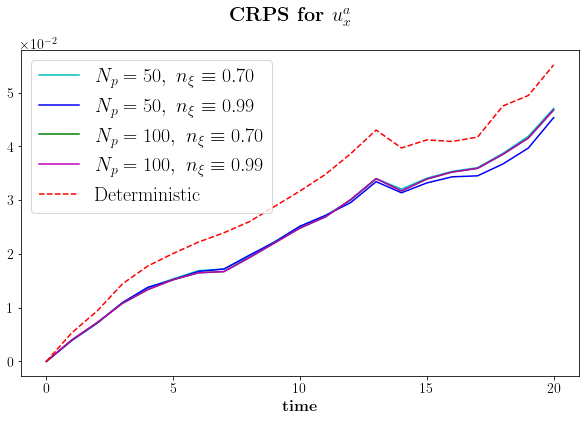

In [105]:
fig, ax = plt.subplots(1,figsize=(10, 6))
c1 = 'c'
c2 = 'blue'
c3 = 'g'
c4 = 'm'

ax.plot(crps_config1[0], color=c1, label=r'$N_p = 50, \ n_{\xi}\equiv 0.70$')
ax.plot(crps_config2[0], color=c2, label=r'$N_p = 50, \ n_{\xi}\equiv 0.99$')
ax.plot(crps_config3[0], color=c3, label=r'$N_p = 100, \ n_{\xi}\equiv 0.70$')
ax.plot(crps_config3[0], color=c4, label=r'$N_p = 100, \ n_{\xi}\equiv 0.99$')
ax.plot(crps_ux_one_det, color='red', linestyle='dashed', label=r'Deterministic')
ax.ticklabel_format(axis='y',style='scientific', scilimits=(0,0), useMathText=True)
ax.set_xticks(np.arange(0,n_tsteps,5))
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.68, 1.1), ncol=2) 
ax.legend()
fig.suptitle(r'\bf CRPS for $u_x^a$')
ax.set_xlabel(r'${ \bf time }$')

Text(0.5, 0, '${ \\bf time }$')

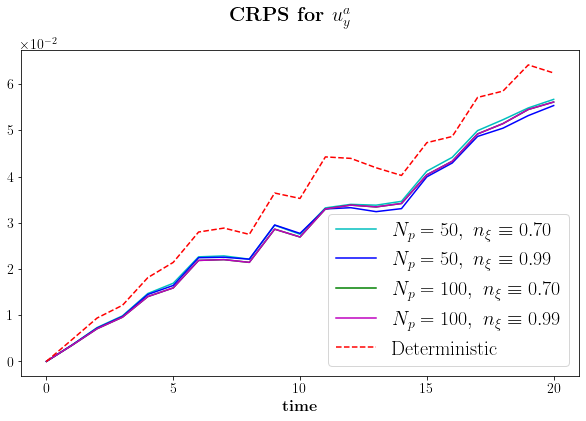

In [106]:
fig, ax = plt.subplots(1,figsize=(10, 6))
c1 = 'c'
c2 = 'blue'
c3 = 'g'
c4 = 'm'

ax.plot(crps_config1[1], color=c1, label=r'$N_p = 50, \ n_{\xi}\equiv 0.70$')
ax.plot(crps_config2[1], color=c2, label=r'$N_p = 50, \ n_{\xi}\equiv 0.99$')
ax.plot(crps_config3[1], color=c3, label=r'$N_p = 100, \ n_{\xi}\equiv 0.70$')
ax.plot(crps_config3[1], color=c4, label=r'$N_p = 100, \ n_{\xi}\equiv 0.99$')
ax.plot(crps_uy_one_det, color='red', linestyle='dashed', label=r'Deterministic')
ax.ticklabel_format(axis='y',style='scientific', scilimits=(0,0), useMathText=True)
ax.set_xticks(np.arange(0,n_tsteps,5))
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.68, 1.1), ncol=2) 
ax.legend()
fig.suptitle(r'\bf CRPS for $u_y^a$')
ax.set_xlabel(r'${ \bf time }$')

Text(0.5, 0, '${ \\bf time }$')

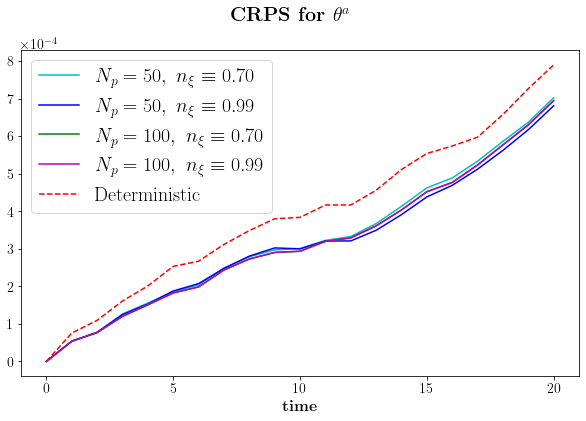

In [107]:
fig, ax = plt.subplots(1,figsize=(10, 6))
c1 = 'c'
c2 = 'blue'
c3 = 'g'
c4 = 'm'

ax.plot(crps_config1[2], color=c1, label=r'$N_p = 50, \ n_{\xi}\equiv 0.70$')
ax.plot(crps_config2[2], color=c2, label=r'$N_p = 50, \ n_{\xi}\equiv 0.99$')
ax.plot(crps_config3[2], color=c3, label=r'$N_p = 100, \ n_{\xi}\equiv 0.70$')
ax.plot(crps_config3[2], color=c4, label=r'$N_p = 100, \ n_{\xi}\equiv 0.99$')
ax.plot(crps_temp_one_det, color='red', linestyle='dashed', label=r'Deterministic')
ax.ticklabel_format(axis='y',style='scientific', scilimits=(0,0), useMathText=True)
ax.set_xticks(np.arange(0,n_tsteps,5))
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.68, 1.1), ncol=2) 
ax.legend()
fig.suptitle(r'\bf CRPS for $\theta^a$')
ax.set_xlabel(r'${ \bf time }$')